# Import libraries

In [1]:
import numpy as np
import scipy
from scipy.stats import spearmanr

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

import keras
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.optimizers import SGD

# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define correlation metric

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.
		:Example:
		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

In [4]:
def spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )

## Define plotting functions

In [34]:
def plot_loss(history):
  plt.plot(history.history['correlate'], label='train')
  plt.plot(history.history['val_correlate'], label='valid')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Correlation score')
  plt.legend()
  plt.grid(True)
  plt.title('Correlation score over learning epochs')

# Set paths

In [5]:
patches_file = "/content/drive/MyDrive/D4GEN/D4GEN_data/mat_5725_patches.npy"
transcription_levels = "/content/drive/MyDrive/D4GEN/D4GEN_data/tr_5725_levels.npy"


## Reshape data

In [6]:
X = np.load(patches_file)
y = np.load(transcription_levels)


X_r = X.reshape((5725,20, 20,1))
y_r = y.reshape((5725,1))



print(f"Shape of X_r : {X_r.shape}")
print(f"Shape of y_r : {y_r.shape}")

Shape of X : (114500, 20)
Shape of y : (5725,)
Reshape X
Shape of X_r : (5725, 20, 20, 1)
Shape of y_r : (5725, 1)


## Show some data

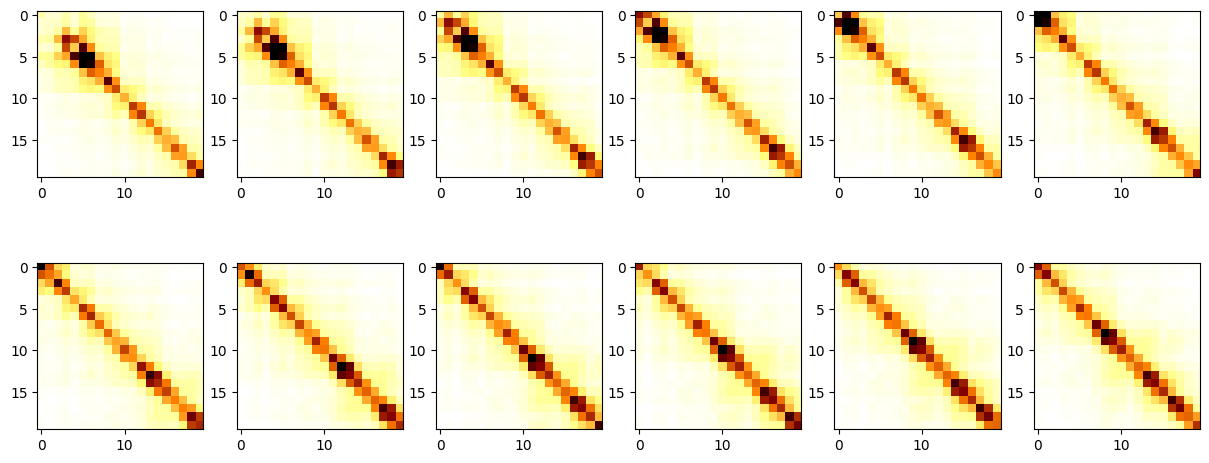

In [7]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = X_r[-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    ax = plt.subplot(grid[idx])
    ax.imshow(X_r[idx], cmap = "afmhot_r")

## Normalized data

In [8]:
X_r = np.divide(np.log1p(X_r) - np.min(np.log1p(X_r)), np.max(np.log1p(X_r)) - np.min(np.log1p(X_r)))

y_r = np.log1p(y_r)

## Plot some normalized data

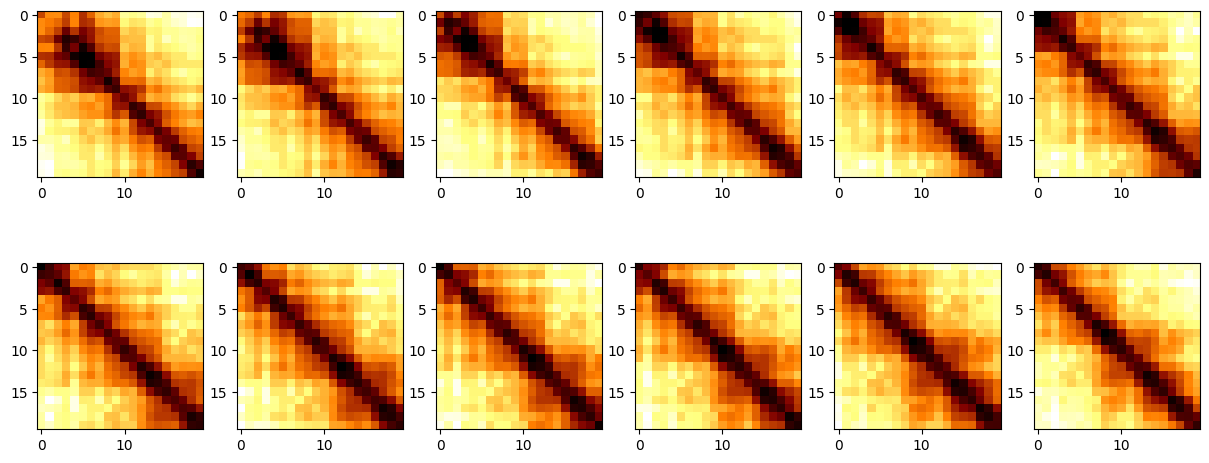

In [9]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = X_r[-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    ax = plt.subplot(grid[idx])
    ax.imshow(X_r[idx], cmap = "afmhot_r")

## Split data

In [35]:
X_r_c_train = X_r[0:5724-199]
y_r_c_train = y_r[0:5724-199]

print(f'Shape of X_r_c_train : {X_r_c_train.shape}')
print(f'Shape of y_r_c_train : {y_r_c_train.shape}')



X_r_c_test = X_r[-199:]
y_r_c_test = y_r[-199:]

print(f'Shape of X_r_c_test : {X_r_c_test.shape}')
print(f'Shape of y_r_c_test : {y_r_c_test.shape}')

Shape of X_r_c_train : (5525, 20, 20, 1)
Shape of y_r_c_train : (5525, 1)
Shape of X_r_c_test : (199, 20, 20, 1)
Shape of y_r_c_test : (199, 1)


## Define model

In [12]:
######## New model #######

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 2, activation='relu', input_shape = (20, 20, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 2, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])


model.compile(tf.keras.optimizers.RMSprop(0.001),
              loss='mse',
              metrics=[correlate, spearman])


model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 19, 19, 16)        80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Train Model

In [13]:
history = model.fit(
    X_r_c_train,
    y_r_c_train,
    epochs=250,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

## Plot performances

# Saving models

In [ ]:
model.save('model_1.h5')


## Plot training process

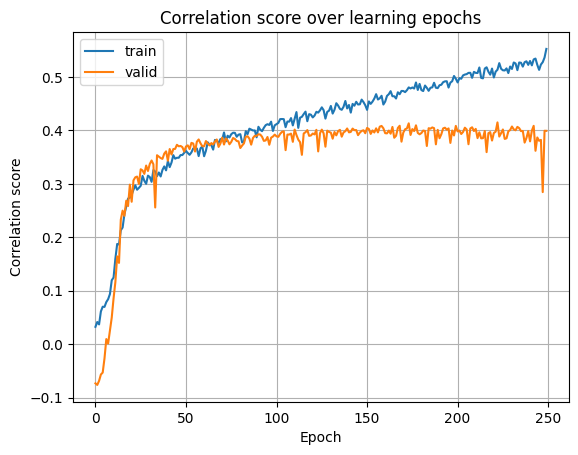

In [24]:
plot_loss(history)

# Prediction

In [25]:
y_r_c_test_hat = model.predict(X_r_c_test)

7/7 [==============================] - 0s 6ms/step


## Prediction plot

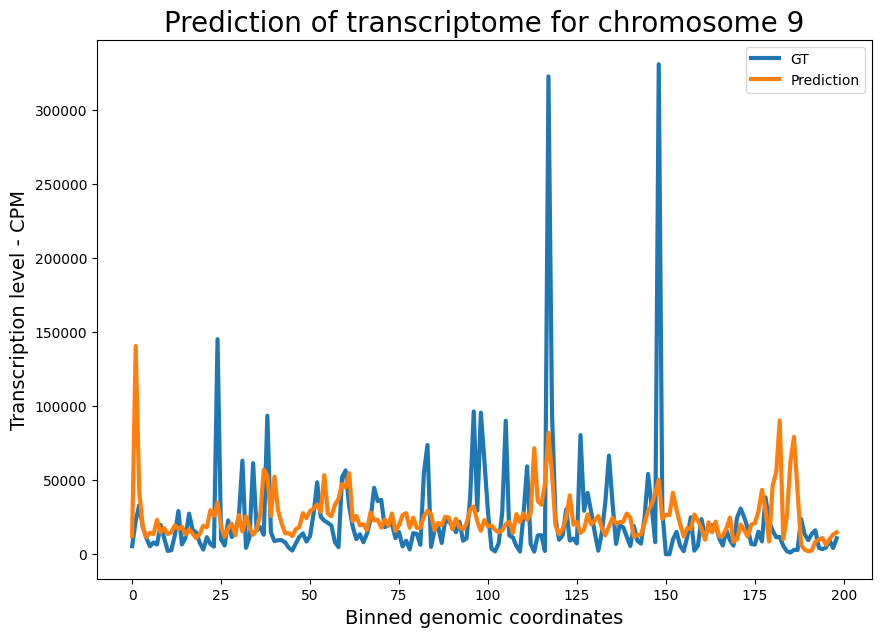

In [26]:
plt.figure(figsize=(10, 7))
plt.plot(np.exp(y_r_c_test), label = 'GT', linewidth = 3)
plt.plot(np.exp(y_r_c_test_hat), label = 'Prediction', linewidth = 3)
plt.title(f"Prediction of transcriptome for chromosome 9", fontsize = 20)
plt.xlabel("Binned genomic coordinates", fontsize = 14)
plt.ylabel("Transcription level - CPM", fontsize = 14)
plt.legend()
plt.show()